In [1]:
!pip install livelossplot

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/glove-twitter/glove.twitter.27B.200d.txt
/kaggle/input/glove-twitter/glove.twitter.27B.25d.txt
/kaggle/input/glove-twitter/glove.twitter.27B.50d.txt
/kaggle/input/glove-twitter/glove.twitter.27B.100d.txt
/kaggle/input/twitter-hate-speech-preprocessing-and-eda/__results__.html
/kaggle/input/twitter-hate-speech-preprocessing-and-eda/twittervalidation.csv
/kaggle/input/twitter-hate-speech-preprocessing-and-eda/__notebook__.ipynb
/kaggle/input/twitter-hate-speech-preprocessing-and-eda/twittertrain.csv
/kaggle/input/twitter-hate-speech-preprocessing-and-eda/__output__.json
/kaggle/input/twitter-hate-speech-preprocessing-and-eda/twittertest.csv
/kaggle/input/twitter-hate-speech-preprocessing-and-eda/custom.css
/kaggle/input/twitter-hate-speech-preprocessing-and-eda/__results___files/__results___9_0.png
/kaggle/input/twitter-hate-speech-preprocessing-and-eda/__results___files/__results___36_0.png
/kaggle/input/twitter-hate-speech-preprocessing-and-eda/__results___files/__results

### Vectorize
1. Using Tfidf
2. Using tensorflow tokenize

3.Build a baseline model using Logistic Regression, handle class imbalance
4. Build a model with GloVe embeddings, trainable = False, LSTM, Conv1d
#Build a model with trained embeddings, LSTM, Conv1d
#Explore Conv1d-LSTM combined architecture

#Handle out of vocabulary tokens


In [3]:
traindata = pd.read_csv("../input/twitter-hate-speech-preprocessing-and-eda/twittertrain.csv")
valdata = pd.read_csv("../input/twitter-hate-speech-preprocessing-and-eda/twittervalidation.csv")
testdata = pd.read_csv("../input/twitter-hate-speech-preprocessing-and-eda/twittertest.csv")

In [4]:
print(traindata.isna().sum())
print(valdata.isna().sum())
print(testdata.isna().sum())

tokenized    51
Sentiment     0
dtype: int64
tokenized    8
Sentiment    0
dtype: int64
tokenized    10
Sentiment     0
dtype: int64


In [5]:
traindata.dropna(inplace=True)
valdata.dropna(inplace=True)
testdata.dropna(inplace=True)

In [6]:
X_train = traindata.drop(columns=['Sentiment'])
y_train = traindata['Sentiment']
X_val = valdata.drop(columns=['Sentiment'])
y_val = valdata['Sentiment']
X_test = testdata.drop(columns=['Sentiment'])
y_test = testdata['Sentiment']

In [7]:
X_train.head()

,tokenized
0,disgust idiot medium go straight islam regard ...
1,dunstaplesummerselfie watch next c min dunstap...
2,quietly hum win way next meeting may drop thug...
3,late post imoy fall :-) cbafamily summerouting...
4,happy enjoy music understand lyric musicisthef...


In [8]:
X_train.shape

(19125, 1)

In [9]:
wordcounts = X_val['tokenized'].apply(lambda x: len(x.split()))
wordcounts.describe()

count    6385.000000
mean       10.360846
std         8.614741
min         1.000000
25%         6.000000
50%         9.000000
75%        12.000000
max       207.000000
Name: tokenized, dtype: float64

(array([5.962e+03, 3.690e+02, 3.900e+01, 6.000e+00, 5.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([  1. ,  21.6,  42.2,  62.8,  83.4, 104. , 124.6, 145.2, 165.8,
        186.4, 207. ]),
 <BarContainer object of 10 artists>)

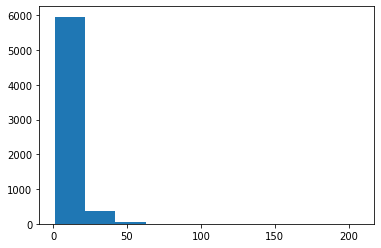

In [10]:
plt.hist(wordcounts)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [12]:
def evaluate(model, Xeval, ytrue):
    ypred = model.predict(Xeval)
    print(f"F1 Score: {f1_score(ytrue,ypred)}")
    mat = confusion_matrix(ytrue, ypred)
    print(f"True positives: {mat[1,1]}, True Negatives: {mat[0,0]}, False Positives: {mat[0,1]}, False Negatives: {mat[1,0]} ")
    print("Recall = ",recall_score(ytrue,ypred))
    

In [13]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train['tokenized'])
X_val_tfidf = tfidf.transform(X_val['tokenized'])
X_test_tfidf = tfidf.transform(X_test['tokenized'])

In [14]:
logReg = LogisticRegression()
logReg.fit(X_train_tfidf,y_train)

LogisticRegression()

In [15]:
print("ordinary logistic regression\n")
print("***Training Data Performance*** \n")
evaluate(logReg, X_train_tfidf,y_train)
print("\n***Validation Data Performance*** \n")
evaluate(logReg, X_val_tfidf,y_val)

ordinary logistic regression

***Training Data Performance*** 

F1 Score: 0.4883720930232558
True positives: 441, True Negatives: 17760, False Positives: 23, False Negatives: 901 
Recall =  0.3286140089418778

***Validation Data Performance*** 

F1 Score: 0.41580756013745707
True positives: 121, True Negatives: 5924, False Positives: 12, False Negatives: 328 
Recall =  0.26948775055679286


The model has high variance, also it's performing poor on positive classes prediction

In [16]:
logReg1 = LogisticRegression(penalty='l1', class_weight='balanced', solver='liblinear')
logReg1.fit(X_train_tfidf,y_train)

LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear')

In [17]:
print("ordinary logistic regression with penalty and balanced class weights\n")
print("***Training Data Performance*** \n")
evaluate(logReg1, X_train_tfidf,y_train)
print("\n***Validation Data Performance*** \n")
evaluate(logReg1, X_val_tfidf,y_val)

ordinary logistic regression with penalty and balanced class weights

***Training Data Performance*** 

F1 Score: 0.7637614678899082
True positives: 1332, True Negatives: 16969, False Positives: 814, False Negatives: 10 
Recall =  0.992548435171386

***Validation Data Performance*** 

F1 Score: 0.6034639927073839
True positives: 331, True Negatives: 5619, False Positives: 317, False Negatives: 118 
Recall =  0.7371937639198218


In [18]:
logReg2 = LogisticRegression(penalty='l1', class_weight='balanced', solver='liblinear', C=0.1)
logReg2.fit(X_train_tfidf,y_train)
print("ordinary logistic regression with penalty and balanced class weights\n")
print("***Training Data Performance*** \n")
evaluate(logReg2, X_train_tfidf,y_train)
print("\n***Validation Data Performance*** \n")
evaluate(logReg2, X_val_tfidf,y_val)

ordinary logistic regression with penalty and balanced class weights

***Training Data Performance*** 

F1 Score: 0.48832156436719176
True positives: 899, True Negatives: 16342, False Positives: 1441, False Negatives: 443 
Recall =  0.6698956780923994

***Validation Data Performance*** 

F1 Score: 0.4757929883138565
True positives: 285, True Negatives: 5472, False Positives: 464, False Negatives: 164 
Recall =  0.6347438752783965


In [19]:
logReg3 = LogisticRegression(penalty='l1', class_weight='balanced', solver='liblinear', C=0.08)
logReg3.fit(X_train_tfidf,y_train)
print("ordinary logistic regression with penalty and balanced class weights\n")
print("***Training Data Performance*** \n")
evaluate(logReg3, X_train_tfidf,y_train)
print("\n***Validation Data Performance*** \n")
evaluate(logReg3, X_val_tfidf,y_val)

ordinary logistic regression with penalty and balanced class weights

***Training Data Performance*** 

F1 Score: 0.4741330301307562
True positives: 834, True Negatives: 16441, False Positives: 1342, False Negatives: 508 
Recall =  0.6214605067064084

***Validation Data Performance*** 

F1 Score: 0.48347826086956525
True positives: 278, True Negatives: 5513, False Positives: 423, False Negatives: 171 
Recall =  0.6191536748329621


In [20]:
logReg4 = LogisticRegression(penalty='l1', class_weight='balanced', solver='liblinear', C=0.5)
logReg4.fit(X_train_tfidf,y_train)
print("ordinary logistic regression with penalty and balanced class weights\n")
print("***Training Data Performance*** \n")
evaluate(logReg4, X_train_tfidf,y_train)
print("\n***Validation Data Performance*** \n")
evaluate(logReg4, X_val_tfidf,y_val)

ordinary logistic regression with penalty and balanced class weights

***Training Data Performance*** 

F1 Score: 0.6584910690482537
True positives: 1235, True Negatives: 16609, False Positives: 1174, False Negatives: 107 
Recall =  0.9202682563338301

***Validation Data Performance*** 

F1 Score: 0.5544388609715243
True positives: 331, True Negatives: 5522, False Positives: 414, False Negatives: 118 
Recall =  0.7371937639198218


In [21]:
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv1D, Embedding, LSTM, Dropout, GlobalMaxPooling1D, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from livelossplot import PlotLossesKeras

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [23]:
max_length = 50
padding_type = 'post'
trunc_type = 'post'

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train['tokenized'])
training_sequences = tokenizer.texts_to_sequences(X_train['tokenized'])
validation_sequences = tokenizer.texts_to_sequences(X_val['tokenized'])
testing_sequences = tokenizer.texts_to_sequences(X_test['tokenized'])
padded_train = pad_sequences(training_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)

padded_val = pad_sequences(validation_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)
padded_test = pad_sequences(testing_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)
word_indices = tokenizer.word_index
vocab_size = len(word_indices.items())

In [24]:
padded_train = np.expand_dims(padded_train, -1)
padded_val = np.expand_dims(padded_val,-1)
padded_test = np.expand_dims(padded_test,-1)
train_labels = y_train.values
val_labels = y_val.values
test_labels = y_test.values

In [25]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes =np.unique(train_labels),y = train_labels)
class_weight_dict = dict(enumerate(class_weights))

In [26]:
def evaluate_model(model,testX,testY):
    ypred = np.round(model.predict(testX))
    return recall_score(testY,ypred)

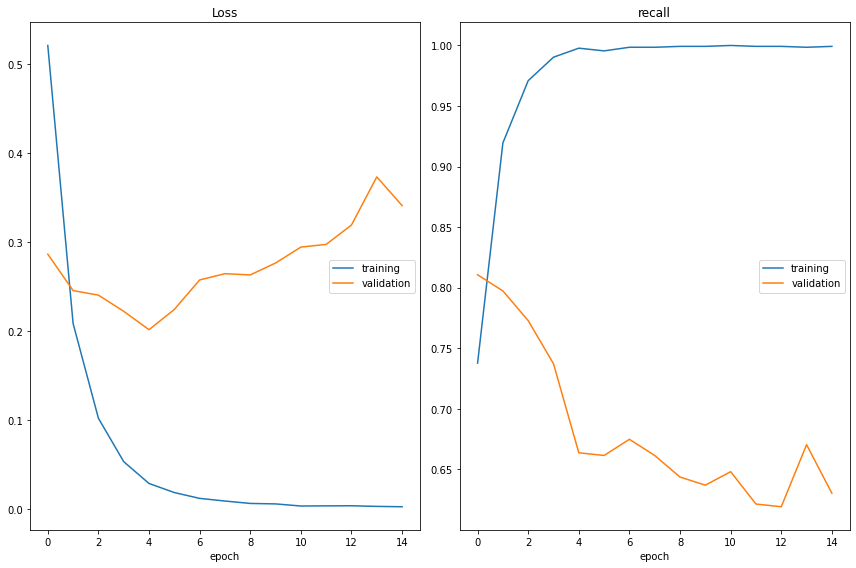

Loss
	training         	 (min:    0.003, max:    0.521, cur:    0.003)
	validation       	 (min:    0.202, max:    0.373, cur:    0.341)
recall
	training         	 (min:    0.738, max:    1.000, cur:    0.999)
	validation       	 (min:    0.619, max:    0.811, cur:    0.630)


In [27]:
model1 = Sequential()
model1.add(Embedding(input_dim = vocab_size+1, input_length=max_length,output_dim=8))
model1.add(Flatten())
model1.add(Dense(10, activation = 'relu'))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=1e-3),metrics=Recall(name='recall'))
print(model1.summary())
model_checkpoint1 = ModelCheckpoint("basic_checkpoint.h5", save_best_only=True, 
                                    monitor='val_recall', mode='max')
num_epochs = 15
history = model1.fit(padded_train, train_labels,epochs=num_epochs,validation_data=(padded_val, val_labels),
                        callbacks=[PlotLossesKeras(),model_checkpoint1], class_weight=class_weight_dict)

In [28]:

model11 = load_model('./basic_checkpoint.h5')

In [29]:
evaluate_model(model11,padded_test, test_labels)

0.8191964285714286

That's a great improvement from baseline model. 

# Using Glove-Twitter Embeddings

In [30]:
def get_glove_embedding_matrix(path_to_file, word_indices):
    
    word_to_vec_map = {}
    with open(path_to_file,'r') as f:
        for line in f:
            word_line = line.split()
            curr_word = word_line[0]
            vector = np.array(word_line[1:], dtype=np.float64)
            word_to_vec_map[curr_word] = vector
            
    embed_dim = len(vector)
    embed_matrix = np.zeros((len(word_indices)+1, embed_dim))
    
    for token,index in word_indices.items():
        if token in word_to_vec_map:
            embed_matrix[index,:] = word_to_vec_map[token]
   
    return embed_matrix

In [31]:
len(word_indices)

12638

In [32]:
embedding_matrix_25d = get_glove_embedding_matrix('../input/glove-twitter/glove.twitter.27B.25d.txt',word_indices)
embedding_matrix_50d = get_glove_embedding_matrix('../input/glove-twitter/glove.twitter.27B.50d.txt',word_indices)
embedding_matrix_100d = get_glove_embedding_matrix('../input/glove-twitter/glove.twitter.27B.100d.txt',word_indices)
embedding_matrix_200d = get_glove_embedding_matrix('../input/glove-twitter/glove.twitter.27B.200d.txt',word_indices)

In [33]:
def get_basic_glove_model(vocab_size, embed_len, embedding_matrix, max_len):
    input_layer = Input(max_len)
    embedding_layer = Embedding(input_dim=vocab_size,output_dim=embed_len,
                                weights = [embedding_matrix], trainable=False)(input_layer)
    flatten = Flatten()(embedding_layer)
    dense1 = Dense(10*0.4*embed_len, activation='relu')(flatten)
    output = Dense(1, activation='sigmoid')(dense1)
    model = Model(input_layer,output)
    model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=1e-3),metrics=Recall(name='recall'))
    return model

In [34]:
def fit_basic_glove_model(model,embed_len,trainX,trainY,valX,valY,num_epochs, class_weights):
    
    model_checkpoint = ModelCheckpoint(f"basic_checkpoint_{embed_len}.h5", 
                                       save_best_only=True, monitor='val_recall',mode='max')
    history = model.fit(trainX, trainY ,epochs=num_epochs,validation_data=(valX, valY),
                    callbacks=[PlotLossesKeras(),model_checkpoint], class_weight=class_weights)
    return model

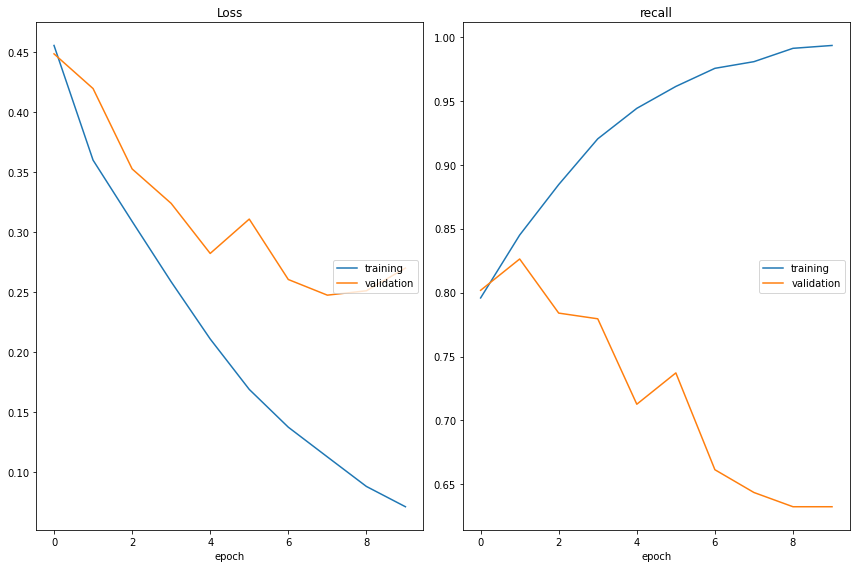

Loss
	training         	 (min:    0.071, max:    0.456, cur:    0.071)
	validation       	 (min:    0.248, max:    0.449, cur:    0.270)
recall
	training         	 (min:    0.796, max:    0.993, cur:    0.993)
	validation       	 (min:    0.633, max:    0.826, cur:    0.633)


In [35]:
model_1_25d = fit_basic_glove_model(get_basic_glove_model(len(word_indices)+1,25,
                                                          embedding_matrix_25d,max_length),
                      25,padded_train,train_labels,padded_val,val_labels,10,class_weight_dict)

In [36]:
model12 = load_model('basic_checkpoint_25.h5')
evaluate_model(model12,padded_test, test_labels)

0.8080357142857143

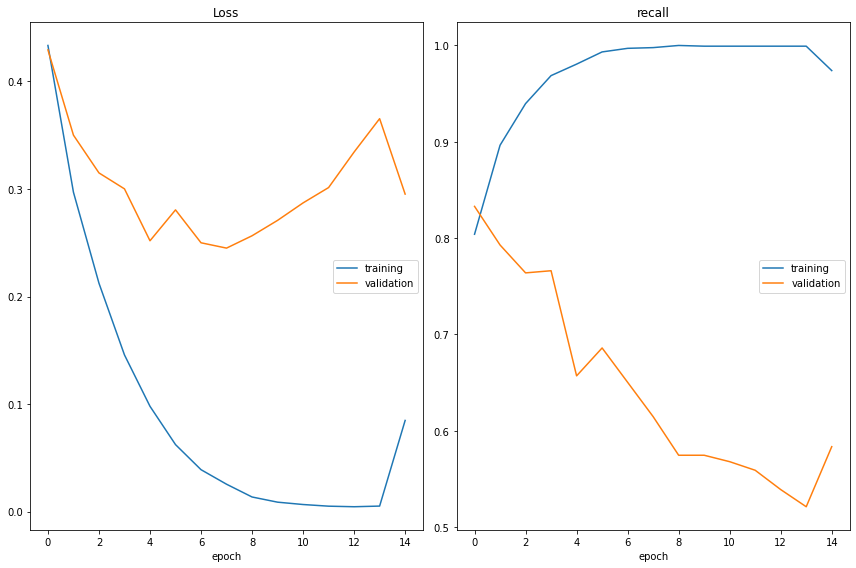

Loss
	training         	 (min:    0.005, max:    0.433, cur:    0.085)
	validation       	 (min:    0.245, max:    0.429, cur:    0.295)
recall
	training         	 (min:    0.804, max:    1.000, cur:    0.974)
	validation       	 (min:    0.521, max:    0.833, cur:    0.584)


In [37]:
model_1_50d = fit_basic_glove_model(get_basic_glove_model(len(word_indices)+1,50,
                                                          embedding_matrix_50d,max_length),
                      50,padded_train,train_labels,padded_val,val_labels,15,class_weight_dict)

In [38]:
model13 = load_model('basic_checkpoint_50.h5')
evaluate_model(model13,padded_test, test_labels)

0.8191964285714286

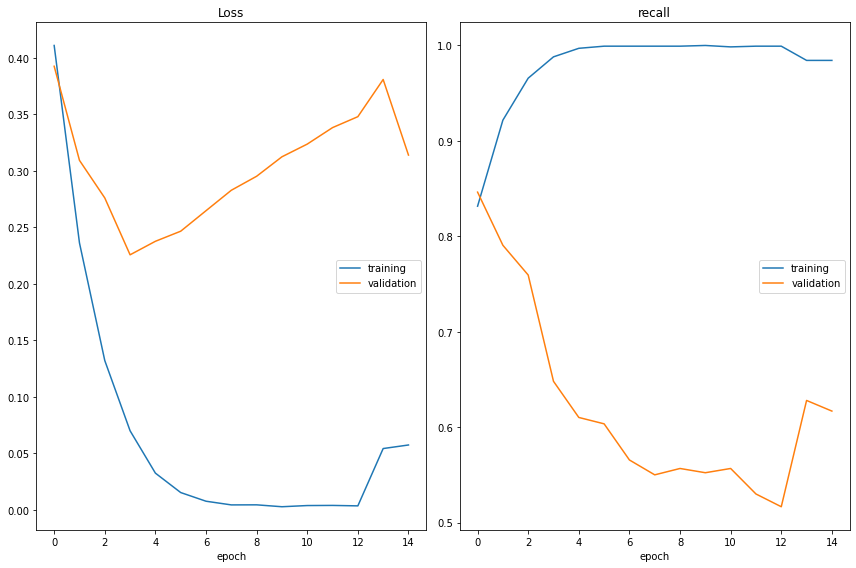

Loss
	training         	 (min:    0.003, max:    0.411, cur:    0.057)
	validation       	 (min:    0.226, max:    0.393, cur:    0.314)
recall
	training         	 (min:    0.832, max:    1.000, cur:    0.984)
	validation       	 (min:    0.517, max:    0.846, cur:    0.617)


In [39]:
model_1_100d = fit_basic_glove_model(get_basic_glove_model(len(word_indices)+1,100,
                                                          embedding_matrix_100d,max_length),
                      100,padded_train,train_labels,padded_val,val_labels,15,class_weight_dict)

In [40]:
model14 = load_model('basic_checkpoint_100.h5')
evaluate_model(model14,padded_test, test_labels)

0.8705357142857143

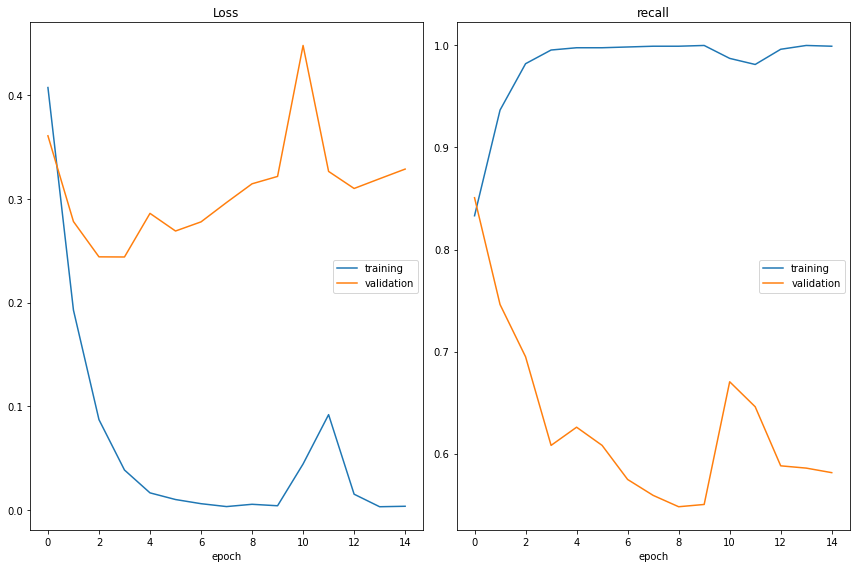

Loss
	training         	 (min:    0.003, max:    0.408, cur:    0.004)
	validation       	 (min:    0.244, max:    0.448, cur:    0.329)
recall
	training         	 (min:    0.833, max:    1.000, cur:    0.999)
	validation       	 (min:    0.548, max:    0.851, cur:    0.581)


In [41]:
model_1_200d = fit_basic_glove_model(get_basic_glove_model(len(word_indices)+1,200,
                                                          embedding_matrix_200d,max_length),
                      200,padded_train,train_labels,padded_val,val_labels,15,class_weight_dict)

In [42]:
model15 = load_model('basic_checkpoint_200.h5')
evaluate_model(model15,padded_test, test_labels)

0.8392857142857143

# Using Convolutional Neural Networks

In [43]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim = vocab_size+1, output_dim=8, input_length=max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(10,activation='relu', kernel_regularizer='l1'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=1e-3),metrics=Recall(name='recall'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 8)             101112    
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 16)            656       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                170       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 101,949
Trainable params: 101,949
Non-trainable params: 0
_________________________________________________________________


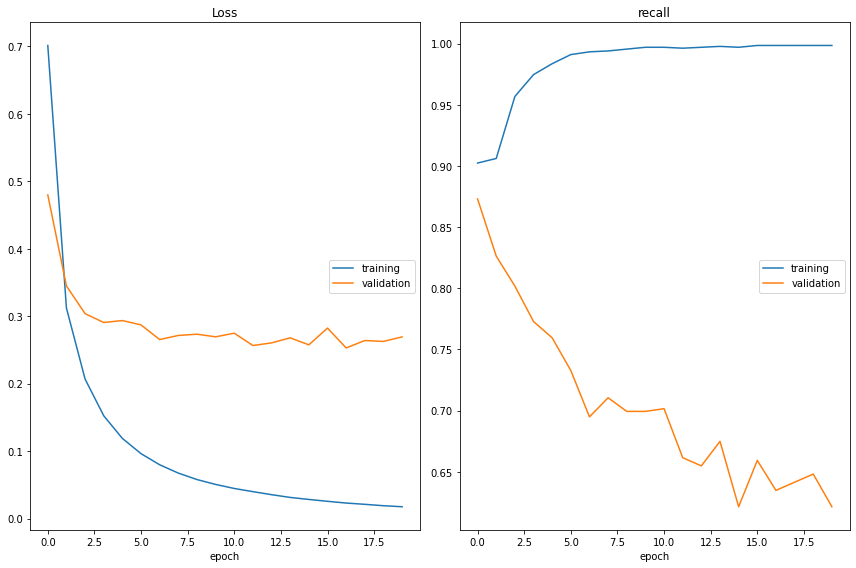

Loss
	training         	 (min:    0.018, max:    0.701, cur:    0.018)
	validation       	 (min:    0.253, max:    0.480, cur:    0.269)
recall
	training         	 (min:    0.902, max:    0.999, cur:    0.999)
	validation       	 (min:    0.621, max:    0.873, cur:    0.621)


In [44]:
model_checkpoint2 = ModelCheckpoint("cnn_checkpoint.h5", save_best_only=True, monitor="val_recall", mode='max')
num_epochs=20
model2.fit(padded_train, train_labels, epochs=num_epochs, 
           validation_data=(padded_val, val_labels), callbacks=[PlotLossesKeras(), model_checkpoint2], 
           class_weight=class_weight_dict)

In [45]:
model21 = load_model('cnn_checkpoint.h5')
evaluate_model(model21,padded_test, test_labels)

0.8861607142857143

In [46]:
from tensorflow.keras import regularizers

In [47]:
embed_len = 25
embedding_matrix = embedding_matrix_25d
model2_100d = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim = vocab_size+1, output_dim=embed_len, input_length=max_length, 
                              weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Conv1D(16, 5, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1,l2=1)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=1e-3),metrics=Recall(name='recall'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 8)             101112    
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 16)            656       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                170       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 101,949
Trainable params: 101,949
Non-trainable params: 0
_________________________________________________________________


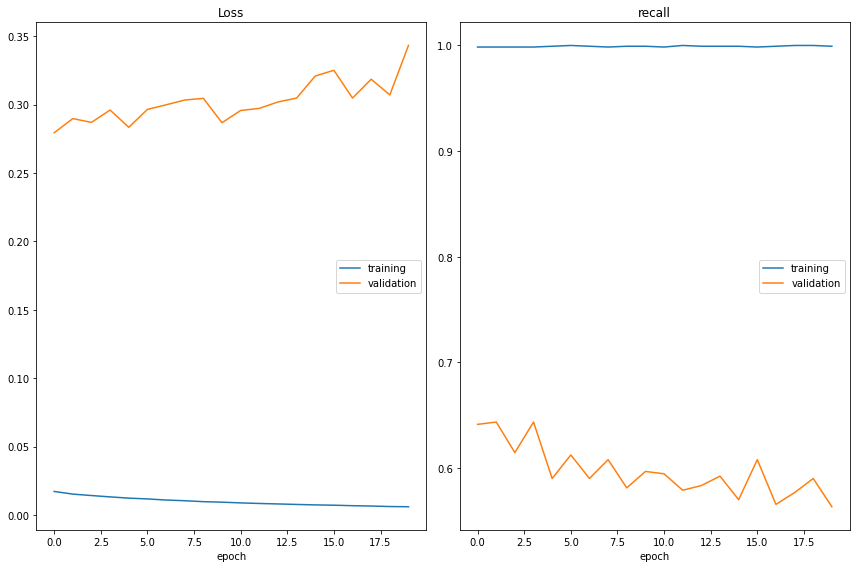

Loss
	training         	 (min:    0.006, max:    0.017, cur:    0.006)
	validation       	 (min:    0.279, max:    0.343, cur:    0.343)
recall
	training         	 (min:    0.999, max:    1.000, cur:    0.999)
	validation       	 (min:    0.563, max:    0.644, cur:    0.563)


In [48]:
model_checkpoint22 = ModelCheckpoint("cnn_checkpoint_25.h5", save_best_only=True, monitor="val_recall", 
                                     mode='max')
num_epochs=20
model2.fit(padded_train, train_labels, epochs=num_epochs, 
           validation_data=(padded_val, val_labels), callbacks=[PlotLossesKeras(), model_checkpoint22], 
           class_weight=class_weight_dict)

# Using LSTM 

In [49]:
embedding_dim = 8

model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 1e-7
model3.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=Recall(name='recall'))
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 8)             101112    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 16)            1088      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                1600      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 103,817
Trainable params: 103,817
Non-trainable params: 0
_________________________________________________________________


Epoch 1/60
598/598 [==============================] - 45s 61ms/step - loss: 0.6933 - recall: 0.0000e+00
Epoch 2/60
598/598 [==============================] - 37s 61ms/step - loss: 0.6933 - recall: 0.0000e+00
Epoch 3/60
598/598 [==============================] - 37s 61ms/step - loss: 0.6933 - recall: 0.0000e+00
Epoch 4/60
598/598 [==============================] - 36s 61ms/step - loss: 0.6933 - recall: 0.0000e+00
Epoch 5/60
598/598 [==============================] - 37s 62ms/step - loss: 0.6933 - recall: 0.0000e+00
Epoch 6/60
598/598 [==============================] - 37s 61ms/step - loss: 0.6933 - recall: 0.0000e+00
Epoch 7/60
598/598 [==============================] - 36s 61ms/step - loss: 0.6933 - recall: 0.0000e+00
Epoch 8/60
598/598 [==============================] - 36s 61ms/step - loss: 0.6933 - recall: 0.0000e+00
Epoch 9/60
598/598 [==============================] - 37s 62ms/step - loss: 0.6933 - recall: 0.0000e+00
Epoch 10/60
598/598 [==============================] - 36s 61ms/

(1e-07, 0.1, 0.0, 1.0)

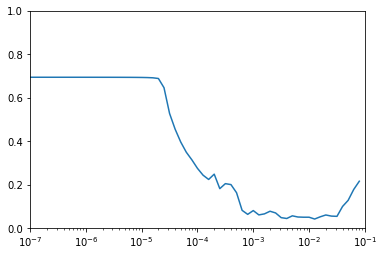

In [50]:
lr_schedule = LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 10))
history_lstm = model3.fit(padded_train, train_labels, epochs=60, callbacks=[lr_schedule],
                          class_weight=class_weight_dict)
plt.semilogx(history_lstm.history["lr"], history_lstm.history["loss"])
plt.axis([1e-7, 1e-1, 0, 1])

Minimum loss is at between 1e-4 to 1e-2, so we can choose 1e-3 as learning rate

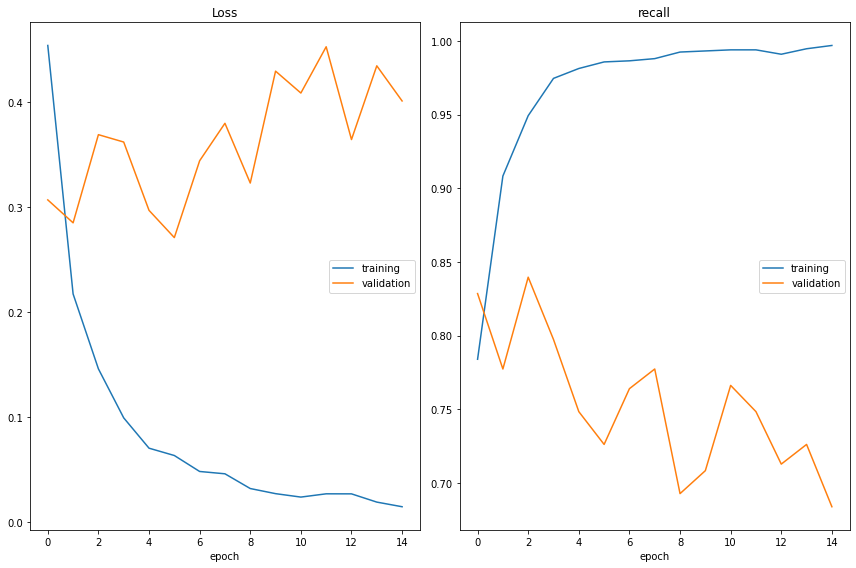

Loss
	training         	 (min:    0.015, max:    0.454, cur:    0.015)
	validation       	 (min:    0.271, max:    0.453, cur:    0.401)
recall
	training         	 (min:    0.784, max:    0.997, cur:    0.997)
	validation       	 (min:    0.684, max:    0.840, cur:    0.684)


In [51]:
embedding_dim = 8

model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 1e-3
model3.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=Recall(name='recall'))
model_checkpoint3 = ModelCheckpoint("lstm_checkpoint.h5", save_best_only=True, monitor="val_recall", 
                                     mode='max')
model3.fit(padded_train, train_labels, epochs=15, validation_data=(padded_val, val_labels),
           callbacks=[PlotLossesKeras(),model_checkpoint3],class_weight=class_weight_dict)

In [52]:
model31 = load_model('lstm_checkpoint.h5')
evaluate_model(model31,padded_test, test_labels)

0.8504464285714286

# Using CNN and LSTM

In [53]:
embedding_dim = 8

model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16,5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 1e-4
model4.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=Recall(name='recall'))
model4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 8)             101112    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 16)            656       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 23, 16)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 23, 32)            4224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 32)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                

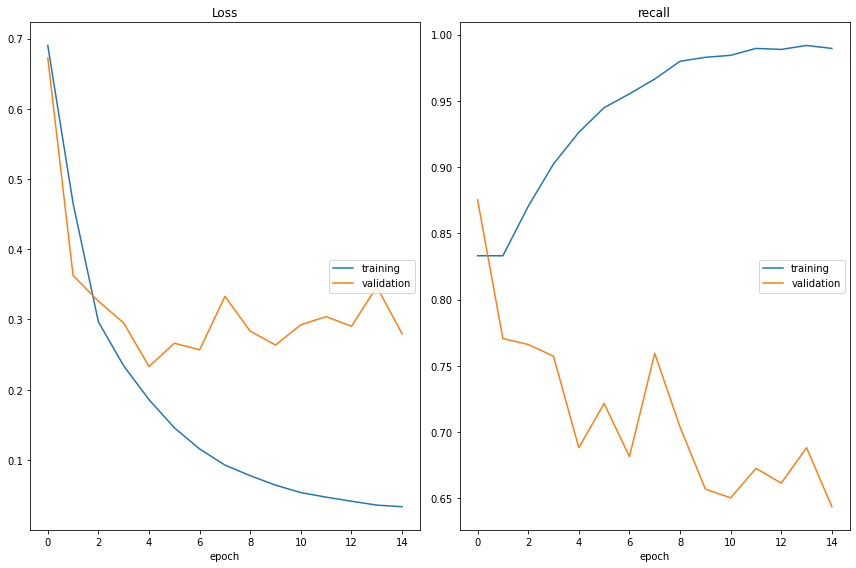

Loss
	training         	 (min:    0.033, max:    0.690, cur:    0.033)
	validation       	 (min:    0.233, max:    0.672, cur:    0.280)
recall
	training         	 (min:    0.833, max:    0.992, cur:    0.990)
	validation       	 (min:    0.644, max:    0.875, cur:    0.644)


In [54]:
model_checkpoint4 = ModelCheckpoint("lstm_cnn_checkpoint.h5", save_best_only=True, monitor="val_recall", 
                                     mode='max')
model4.fit(padded_train, train_labels, epochs=15, validation_data=(padded_val, val_labels),
           callbacks=[PlotLossesKeras(),model_checkpoint4],class_weight=class_weight_dict)

In [55]:
model41 = load_model('lstm_cnn_checkpoint.h5')
evaluate_model(model41,padded_test, test_labels)

0.8727678571428571

In [56]:
ypred_test = np.round(model41.predict(padded_test))
f1_score(test_labels,ypred_test)

0.19232661091982292

In [57]:
confusion_matrix(test_labels,ypred_test)

array([[2708, 3227],
       [  57,  391]])